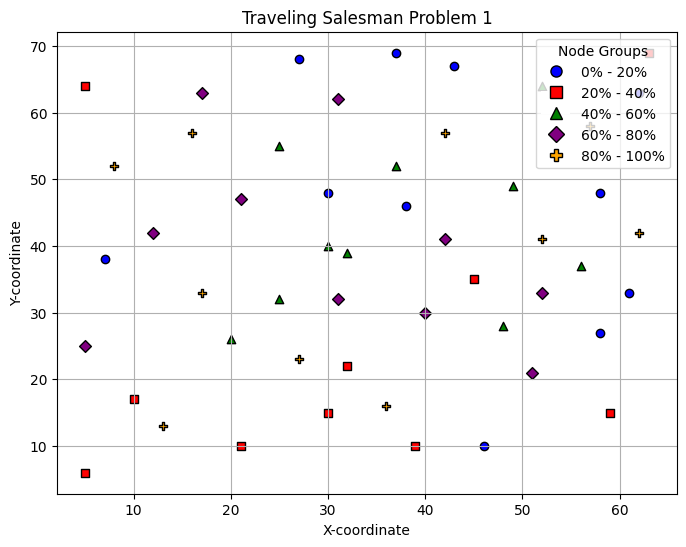

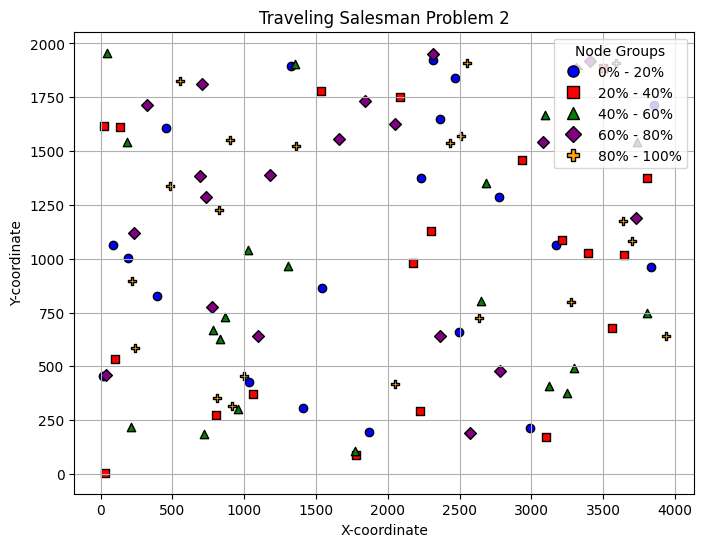

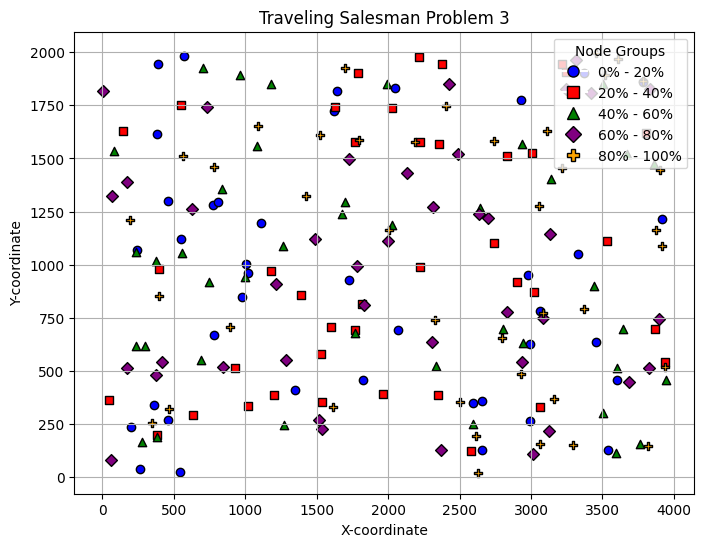

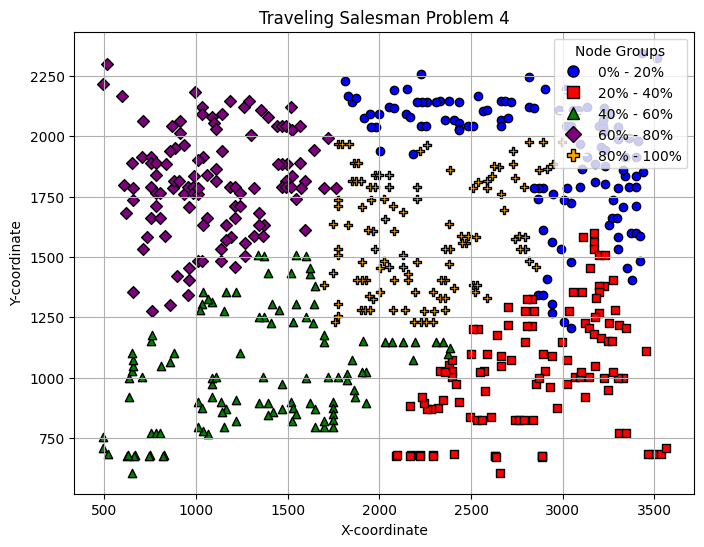

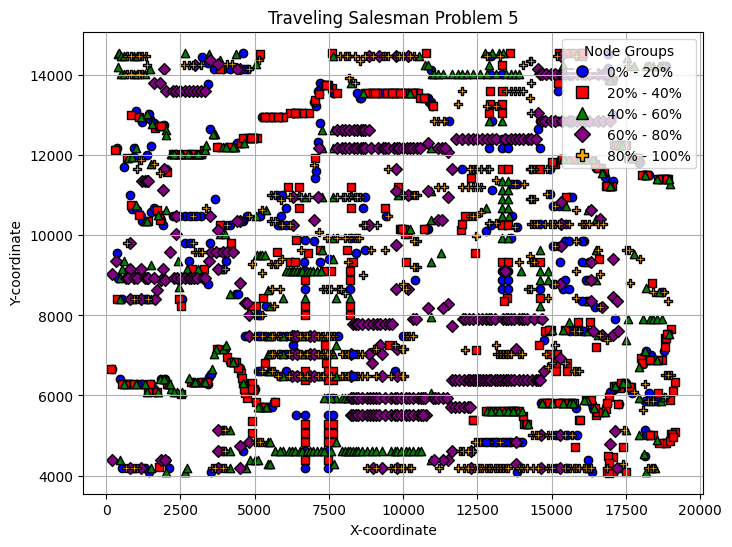

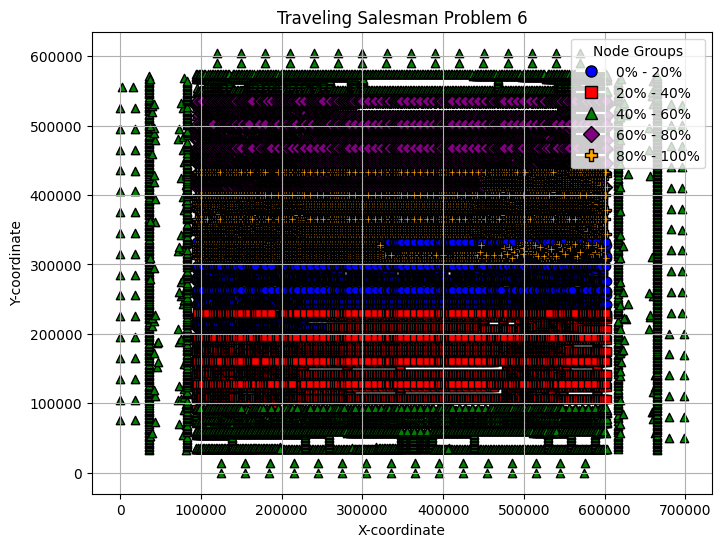

In [2]:
import os
import matplotlib.pyplot as plt
from solver import parse_input_data  # Import parse_input_data from solver.py

# Input data directory
input_folder = r'C:\Users\comne\coursera\Discrete Optimization\tsp\data'

# Define the six specific files to process
selected_files = {
    "Traveling Salesman Problem 1": "tsp_51_1",
    "Traveling Salesman Problem 2": "tsp_100_3",
    "Traveling Salesman Problem 3": "tsp_200_2",
    "Traveling Salesman Problem 4": "tsp_574_1",
    "Traveling Salesman Problem 5": "tsp_1889_1",
    "Traveling Salesman Problem 6": "tsp_33810_1"
}

# Color list (for different 20% node groups)
colors = ['blue', 'red', 'green', 'purple', 'orange']

# Marker styles (for different 20% node groups)
markers = ['o', 's', '^', 'D', 'P']  # Circle, Square, Triangle, Diamond, Pentagon

# Function to visualize TSP nodes with different colors & shapes for every 20% of total nodes
def plot_points(points, node_count, title):
    plt.figure(figsize=(8, 6))

    # Determine the interval for color & marker changes (every 20% of total nodes)
    group_size = max(1, node_count // 5)  # 20% intervals (node_count / 5)
    legend_labels = {}  # Dictionary to store labels for the legend

    for idx, point in enumerate(points):
        # Assign color and marker based on the node group (every 20%)
        group_index = (idx // group_size) % len(colors)
        color = colors[group_index]
        marker = markers[group_index]

        # Plot each node with the assigned color and shape
        plt.scatter(point.x, point.y, c=color, marker=marker, edgecolors='black')  
        
        # Store the color & shape group label (avoiding duplicates in the legend)
        if group_index not in legend_labels:
            legend_labels[group_index] = f"{group_index * 20}% - {(group_index + 1) * 20}%"

    # Add a legend to indicate node group colors & shapes
    legend_handles = [plt.Line2D([0], [0], marker=markers[idx], color='w', 
                                 markerfacecolor=colors[idx], markersize=8, 
                                 markeredgecolor='black', label=label)
                      for idx, label in legend_labels.items()]
    
    plt.legend(handles=legend_handles, title="Node Groups", loc="upper right")

    # Set plot title and labels
    plt.title(title)
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

# Process only the six selected files
for problem_name, file_name in selected_files.items():
    file_path = os.path.join(input_folder, file_name)
    
    # Only process files that exist
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            input_data = file.read()
        
        # Parse input data (convert it into Point objects)
        points, node_count = parse_input_data(input_data)

        # Visualize the points with different colors & shapes for each 20% group
        plot_points(points, node_count, f"{problem_name}")


K-Means converged in 5 iterations.


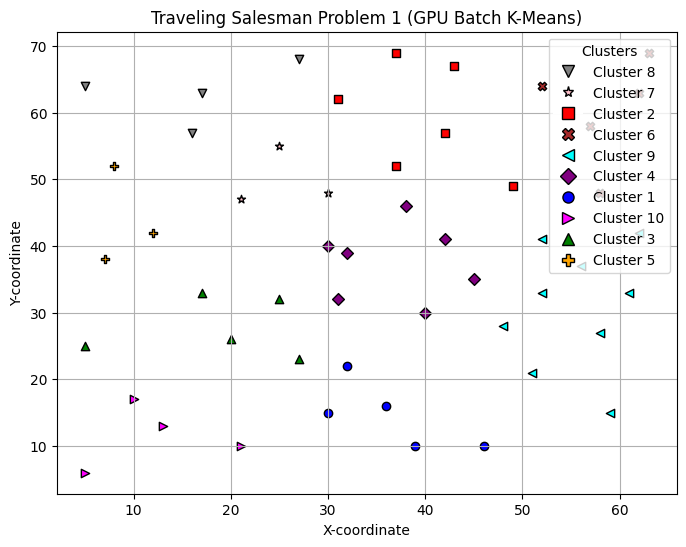

K-Means converged in 7 iterations.


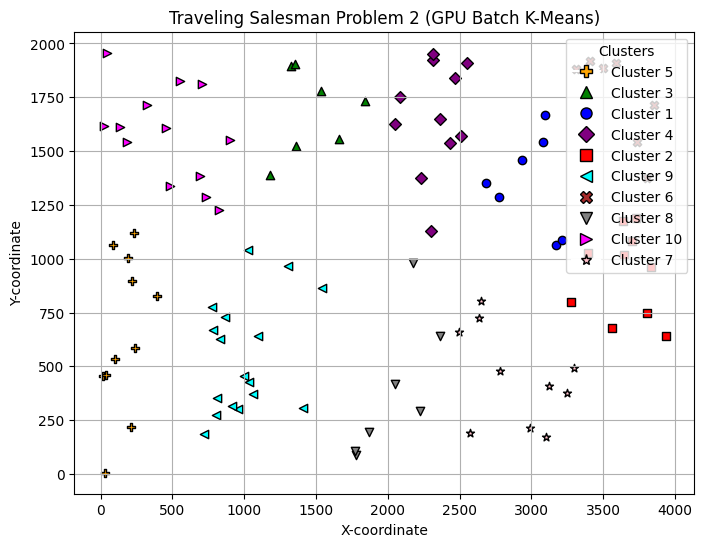

K-Means converged in 9 iterations.


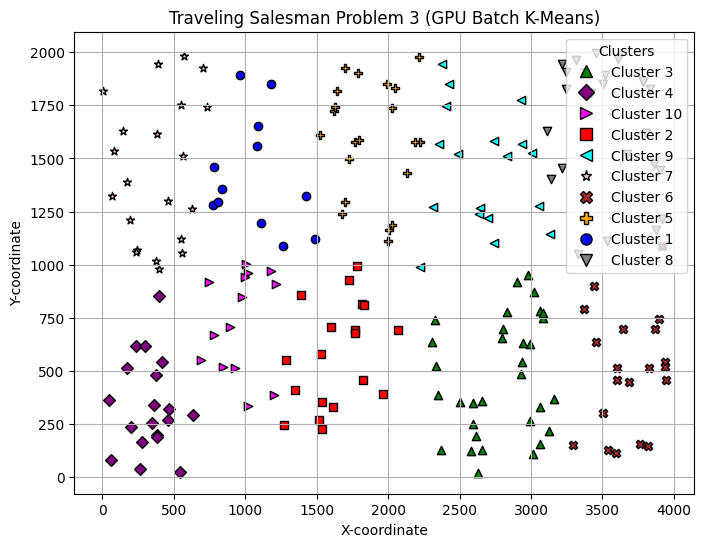

K-Means converged in 13 iterations.


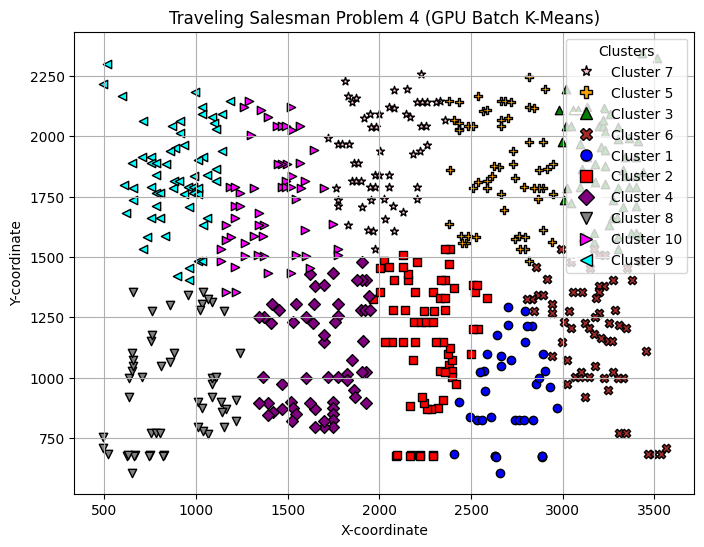

K-Means converged in 41 iterations.


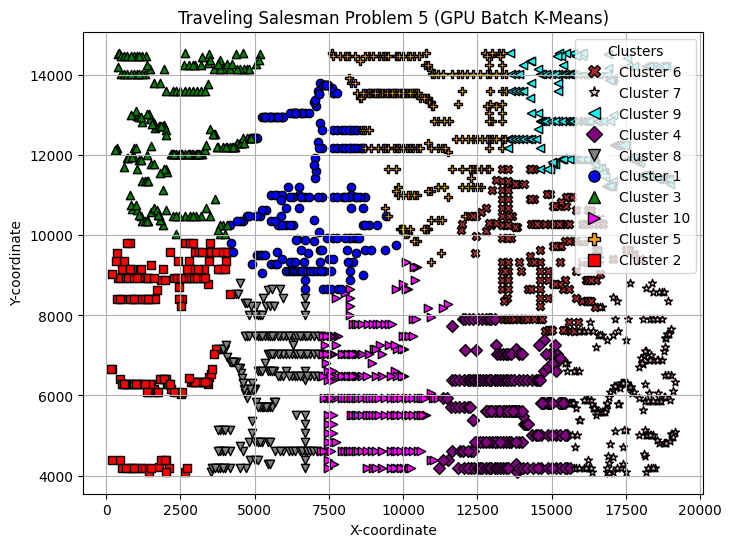

K-Means converged in 48 iterations.


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from solver import parse_input_data  # Import function to read input data

# Input data directory
input_folder = r'C:\Users\comne\coursera\Discrete Optimization\tsp\data'

# Define the six specific files to process
selected_files = {
    "Traveling Salesman Problem 1": "tsp_51_1",
    "Traveling Salesman Problem 2": "tsp_100_3",
    "Traveling Salesman Problem 3": "tsp_200_2",
    "Traveling Salesman Problem 4": "tsp_574_1",
    "Traveling Salesman Problem 5": "tsp_1889_1",
    "Traveling Salesman Problem 6": "tsp_33810_1"
}

# Color list (for 10 clusters)
colors = ['blue', 'red', 'green', 'purple', 'orange', 
          'brown', 'pink', 'gray', 'cyan', 'magenta']

# Marker styles (for 10 clusters)
markers = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>']

# PyTorch-based Batch K-Means
def kmeans_pytorch(X, num_clusters=10, batch_size=1000, max_iters=100, tol=1e-4, device=None):
    """
    Batch-based K-Means Clustering in PyTorch.

    Parameters:
    - X: torch.Tensor (N, D) -> Input data (N samples, D dimensions)
    - num_clusters: int -> Number of clusters (default=10)
    - batch_size: int -> Batch size for efficient processing
    - max_iters: int -> Maximum number of iterations
    - tol: float -> Convergence threshold
    - device: str -> 'cuda' for GPU, 'cpu' for CPU (auto-detects if None)

    Returns:
    - labels: torch.Tensor (N,) -> Cluster assignments
    - centroids: torch.Tensor (num_clusters, D) -> Final cluster centroids
    """
    # Auto-detect device (use GPU if available)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    X = torch.tensor(X, dtype=torch.float32, device=device)  # Move data to device
    N, D = X.shape  # Number of points, dimensions

    # Randomly initialize cluster centroids from input points
    centroids = X[torch.randperm(N)[:num_clusters]].clone()

    prev_centroids = torch.zeros_like(centroids)
    labels = torch.zeros(N, dtype=torch.long, device=device)

    for i in range(max_iters):
        # Compute distances from each point to each centroid
        distances = torch.cdist(X, centroids)  # (N, num_clusters)

        # Assign each point to the nearest centroid
        labels = torch.argmin(distances, dim=1)

        # Compute new centroids (batch update)
        for k in range(num_clusters):
            mask = labels == k
            if mask.any():  # Only update if there are points assigned
                centroids[k] = X[mask].mean(dim=0)

        # Check for convergence
        shift = torch.norm(centroids - prev_centroids, p=2, dim=1).mean().item()
        if shift < tol:
            print(f"K-Means converged in {i+1} iterations.")
            break
        prev_centroids = centroids.clone()

    return labels.cpu().numpy(), centroids.cpu().numpy()  # Return as NumPy arrays

# Function to perform clustering and visualize TSP nodes
def plot_clusters(points, labels, num_clusters, title):
    plt.figure(figsize=(8, 6))

    # Dictionary to store cluster labels for legend
    legend_labels = {}

    # Plot each node with its assigned cluster color and shape
    for idx, point in enumerate(points):
        cluster_id = labels[idx] % num_clusters  # Ensure color cycling
        color = colors[cluster_id]
        marker = markers[cluster_id]

        plt.scatter(point.x, point.y, c=color, marker=marker, edgecolors='black')  
        
        # Store unique cluster label (for legend)
        if cluster_id not in legend_labels:
            legend_labels[cluster_id] = f"Cluster {cluster_id + 1}"

    # Add legend for clusters
    legend_handles = [plt.Line2D([0], [0], marker=markers[idx], color='w', 
                                 markerfacecolor=colors[idx], markersize=8, 
                                 markeredgecolor='black', label=label)
                      for idx, label in legend_labels.items()]
    
    plt.legend(handles=legend_handles, title="Clusters", loc="upper right")

    # Set plot title and labels
    plt.title(f"{title} (GPU Batch K-Means)")
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.show()

# Process only the six selected files
for problem_name, file_name in selected_files.items():
    file_path = os.path.join(input_folder, file_name)
    
    # Only process files that exist
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            input_data = file.read()
        
        # Parse input data (convert it into Point objects)
        points, node_count = parse_input_data(input_data)

        # Convert points to numpy array for clustering
        coords = np.array([[point.x, point.y] for point in points], dtype=np.float32)

        # Run PyTorch K-Means Clustering on GPU (if available)
        labels, centroids = kmeans_pytorch(coords, num_clusters=10, batch_size=500)

        # Visualize clusters
        plot_clusters(points, labels, num_clusters=10, title=problem_name)
